In [5]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [6]:
# Load the dataset
df = pd.read_csv('uganda_traffic_forecasting.csv')

In [7]:
# Convert types
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df['vehicle_count'] = pd.to_numeric(df['vehicle_count'], errors='coerce')
df['avg_speed'] = pd.to_numeric(df['avg_speed'], errors='coerce')
df['target_congestion_level'] = pd.to_numeric(df['target_congestion_level'], errors='coerce')
df['is_holiday'] = pd.to_numeric(df['is_holiday'], errors='coerce')

In [8]:
# 1. Initial Exploration
print("Dataset Shape:", df.shape)
print("\nFirst 5 Rows:")
print(df.head())

Dataset Shape: (1538, 11)

First 5 Rows:
            timestamp location_id  vehicle_count  avg_speed weather  \
0 2023-01-01 03:00:00      ENT002           23.0  40.720369   Clear   
1 2023-01-01 03:15:00      GUL004           15.0  37.877910   Rainy   
2 2023-01-01 03:30:00      GUL004           21.0  30.480815   Clear   
3 2023-01-01 03:45:00      MBR003           25.0  40.774805   Rainy   
4 2023-01-01 04:00:00      GUL004           15.0  42.577525   Snowy   

  day_of_week  is_holiday     event sensor_status road_condition  \
0    Thursday         0.0    Parade          FAIL           Good   
1     Tuesday         0.0    Parade          FAIL           Poor   
2    Saturday         1.0  Marathon            OK       Moderate   
3      Monday         0.0       NaN       UNKNOWN            ???   
4      Friday         0.0  Marathon            OK       Moderate   

   target_congestion_level  
0                      0.0  
1                      1.0  
2                      2.0  
3      

In [9]:
# 2. Check Data Types and Basic Info
print("\nData Types and Non-Null Counts:")
print(df.info())


Data Types and Non-Null Counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1538 entries, 0 to 1537
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   timestamp                1533 non-null   datetime64[ns]
 1   location_id              1534 non-null   object        
 2   vehicle_count            1528 non-null   float64       
 3   avg_speed                1533 non-null   float64       
 4   weather                  1533 non-null   object        
 5   day_of_week              1533 non-null   object        
 6   is_holiday               1527 non-null   float64       
 7   event                    1155 non-null   object        
 8   sensor_status            1538 non-null   object        
 9   road_condition           1536 non-null   object        
 10  target_congestion_level  1532 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(6)
memory usage: 132.

In [10]:
# 3. Identify Missing Values
# First, standardize missing value representations
df.replace('???', np.nan, inplace=True)
df.replace('', np.nan, inplace=True)
df.replace('UNKNOWN', np.nan, inplace=True)  # If we consider UNKNOWN as missing for sensor_status

In [11]:
# Calculate missing values
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100

In [12]:
# Create a summary DataFrame
missing_summary = pd.DataFrame({
    'Missing Values': missing_data,
    'Percentage (%)': missing_percent.round(2)
}).sort_values('Percentage (%)', ascending=False)

print("\nMissing Values Summary:")
print(missing_summary)


Missing Values Summary:
                         Missing Values  Percentage (%)
sensor_status                       506           32.90
event                               391           25.42
is_holiday                           11            0.72
vehicle_count                        10            0.65
location_id                           9            0.59
weather                               9            0.59
target_congestion_level               6            0.39
timestamp                             5            0.33
avg_speed                             5            0.33
day_of_week                           5            0.33
road_condition                        5            0.33


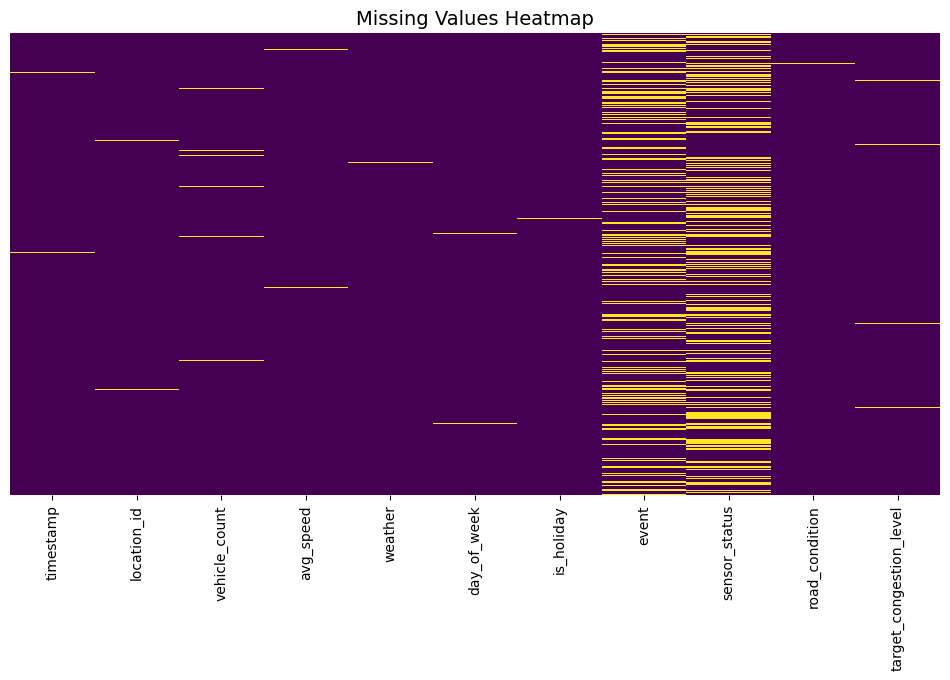

In [13]:
# 4. Visualize Missing Data
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Values Heatmap', fontsize=14)
plt.show()

In [14]:
# 5. Additional Analysis for Key Columns
print("\nUnique Values in Categorical Columns:")
print("Weather:", df['weather'].unique())
print("Road Condition:", df['road_condition'].unique())
print("Sensor Status:", df['sensor_status'].unique())


Unique Values in Categorical Columns:
Weather: ['Clear' 'Rainy' 'Snowy' 'Foggy' nan]
Road Condition: ['Good' 'Poor' 'Moderate' nan]
Sensor Status: ['FAIL' 'OK' nan]


In [15]:
# 6. Temporal Analysis (check for missing timestamps)
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
print("\nTime Range:", df['timestamp'].min(), "to", df['timestamp'].max())


Time Range: 2023-01-01 03:00:00 to 2023-01-16 17:45:00


In [16]:
# Check for irregular time intervals
time_diff = df['timestamp'].diff().value_counts()
print("\nCommon Time Intervals Between Readings:")
print(time_diff.head())


Common Time Intervals Between Readings:
timestamp
0 days 00:15:00      1331
0 days 00:30:00        70
0 days 00:45:00         6
-5 days +12:00:00       2
-8 days +06:15:00       2
Name: count, dtype: int64


In [17]:
#Missing values before handling
missing_before = df.isnull().sum()
print("Missing Values Before Handling:")
print(missing_before[missing_before > 0])

Missing Values Before Handling:
timestamp                    5
location_id                  9
vehicle_count               10
avg_speed                    5
weather                      9
day_of_week                  5
is_holiday                  11
event                      391
sensor_status              506
road_condition               5
target_congestion_level      6
dtype: int64


In [18]:
#Key distributions before handling
# Numerical features
print("\nVehicle Count Stats (Before):")
print(df['vehicle_count'].describe())

# Categorical features
print("\nWeather Value Counts (Before):")
print(df['weather'].value_counts(dropna=False))


Vehicle Count Stats (Before):
count    1528.000000
mean       19.907723
std         4.591213
min         7.000000
25%        17.000000
50%        20.000000
75%        23.000000
max        36.000000
Name: vehicle_count, dtype: float64

Weather Value Counts (Before):
weather
Rainy    396
Foggy    392
Snowy    384
Clear    357
NaN        9
Name: count, dtype: int64


In [19]:
# Implement the chosen methods
# 1. Drop rows with missing timestamps/locations (critical fields)
df = df.dropna(subset=['timestamp', 'location_id'])

# 2. Convert timestamp and extract hour
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour

# 3. Numerical imputation (median by location+hour)
num_cols = ['vehicle_count', 'avg_speed']
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col] = df.groupby(['location_id', 'hour'])[col].transform(
        lambda x: x.fillna(x.median())
    )

# 4. Categorical imputation (mode by location)
cat_cols = ['weather', 'road_condition']
for col in cat_cols:
    df[col] = df.groupby('location_id')[col].transform(
        lambda x: x.fillna(x.mode()[0])
    )

# 5. Retain 'UNKNOWN' sensor status
df['sensor_status'] = df['sensor_status'].fillna('UNKNOWN')

In [20]:
# Handle missing values safely
df['vehicle_count'] = df['vehicle_count'].fillna(df['vehicle_count'].median())
df['avg_speed'] = df['avg_speed'].fillna(df['avg_speed'].median())
df['weather'] = df['weather'].fillna('Unknown')
df['road_condition'] = df['road_condition'].fillna('Unknown')
df['sensor_status'] = df['sensor_status'].fillna('UNKNOWN')
df['event'] = df['event'].fillna('None')
df['location_id'] = df['location_id'].fillna('Unknown')
df['day_of_week'] = df['day_of_week'].fillna('Unknown')
df['is_holiday'] = df['is_holiday'].fillna(0)
df['target_congestion_level'] = df['target_congestion_level'].fillna(0)
df['timestamp'] = df['timestamp'].fillna(method='ffill')  # Forward fill timestamps

C:\Users\oba phillip\AppData\Local\Temp\ipykernel_8660\3437467051.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['timestamp'] = df['timestamp'].fillna(method='ffill')  # Forward fill timestamps


In [21]:
# Re-check missing values
missing_summary = df.isnull().sum().to_frame(name="Missing Values")
missing_summary["Percentage (%)"] = (missing_summary["Missing Values"] / len(df)) * 100
print(missing_summary)

                         Missing Values  Percentage (%)
timestamp                             0             0.0
location_id                           0             0.0
vehicle_count                         0             0.0
avg_speed                             0             0.0
weather                               0             0.0
day_of_week                           0             0.0
is_holiday                            0             0.0
event                                 0             0.0
sensor_status                         0             0.0
road_condition                        0             0.0
target_congestion_level               0             0.0
hour                                  0             0.0


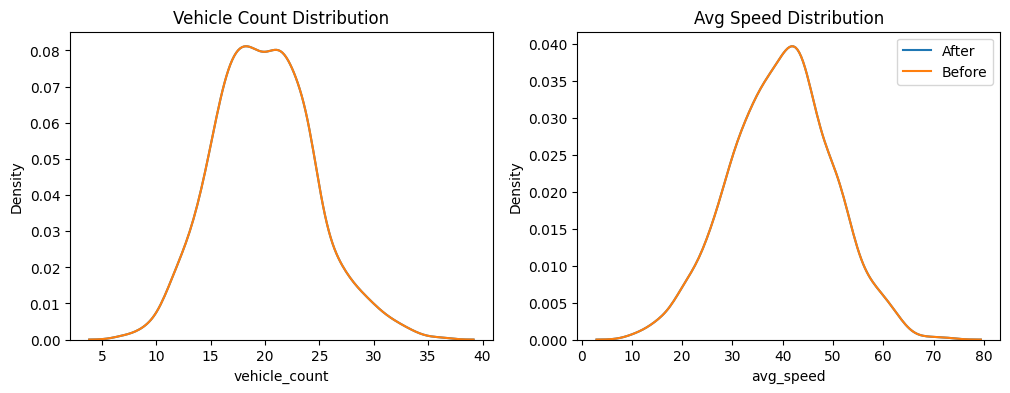

In [22]:
# Distribution comparison
# Numerical feature comparison
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.kdeplot(data=df, x='vehicle_count', ax=ax[0], label='After')
sns.kdeplot(data=pd.to_numeric(df['vehicle_count'], errors='coerce').dropna(), 
            ax=ax[0], label='Before')
ax[0].set_title('Vehicle Count Distribution')

sns.kdeplot(data=df, x='avg_speed', ax=ax[1], label='After')
sns.kdeplot(data=pd.to_numeric(df['avg_speed'], errors='coerce').dropna(), 
            ax=ax[1], label='Before')
ax[1].set_title('Avg Speed Distribution')
plt.legend()
plt.show()

In [23]:
# Categorical feature changes
print("\nWeather Value Counts (After):")
print(df['weather'].value_counts())

print("\nRoad Condition Value Counts (After):")
print(df['road_condition'].value_counts())


Weather Value Counts (After):
weather
Rainy    391
Foggy    391
Snowy    384
Clear    358
Name: count, dtype: int64

Road Condition Value Counts (After):
road_condition
Good        519
Poor        516
Moderate    489
Name: count, dtype: int64


In [24]:
# Statistical significance test(Example for vehicle_count)

original = pd.to_numeric(df['vehicle_count'], errors='coerce').dropna()
imputed = df['vehicle_count']

ks_stat, p_value = ks_2samp(original, imputed)
print(f"\nKS-Test for vehicle_count: p-value = {p_value:.4f}")
# p-value > 0.05 suggests no significant distribution change


KS-Test for vehicle_count: p-value = 1.0000


In [25]:
#KS test for avg_speed(Kolmogorov–Smirnov (KS) test for numerical data.)
# Convert avg_speed to numeric
df['avg_speed'] = pd.to_numeric(df['avg_speed'], errors='coerce')

# Save original (non-null) values before imputation
original_avg_speed = df['avg_speed'].dropna()

# Impute missing values (e.g., using median)
df['avg_speed'] = df['avg_speed'].fillna(df['avg_speed'].median())

# Save imputed column
imputed_avg_speed = df['avg_speed']

# Perform KS-Test
ks_stat_avg, p_value_avg = ks_2samp(original_avg_speed, imputed_avg_speed)

print(f"\nKS-Test for avg_speed: p-value = {p_value_avg:.4f}")

# Interpretation
if p_value_avg > 0.05:
    print("→ No significant distribution change after imputation.")
else:
    print("→ Significant distribution change after imputation.")


KS-Test for avg_speed: p-value = 1.0000
→ No significant distribution change after imputation.


In [26]:
# Data Quality Report
quality_report = pd.DataFrame({
    'Feature': ['vehicle_count', 'avg_speed', 'weather'],
    'Missing_Before': [
        missing_before['vehicle_count'],
        missing_before['avg_speed'],
        missing_before['weather']
    ],
    'Missing_After': [0, 0, 0],
    'Distribution_Change': [
        'Minimal' if p_value > 0.05 else 'Significant',      # for vehicle_count
        'Minimal' if p_value_avg > 0.05 else 'Significant',  # for avg_speed
        'Not Tested'                                          # for weather (categorical)
    ]
})

   


In [27]:
# Feature engineering implementation
# Feature Engineering
# Define a function to create new features based on existing data

# 1. Temporal Features
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
df['is_peak'] = df['hour'].isin([7, 8, 17, 18]).astype(int)  # Rush hours

# 2. Event Impact Features
df['has_accident'] = df['event'].str.contains('Accident').fillna(0).astype(int)
df['has_special_event'] = df['event'].isin(['Parade', 'Marathon']).fillna(0).astype(int)

# 3. Traffic Pattern Features
df['congestion_level'] = pd.cut(df['target_congestion_level'], 
                               bins=[-1, 1, 3, 5],
                               labels=['low', 'medium', 'high'])

# 4. Rolling Averages (by location)
df['rolling_4hr_vehicles'] = df.groupby('location_id')['vehicle_count'].transform(
    lambda x: x.rolling(4, min_periods=1).mean()
)

# 5. Weather Impact Encoding
weather_severity = {
    'Clear': 0,
    'Foggy': 1,
    'Rainy': 2,
    'Snowy': 3
}
df['weather_severity'] = df['weather'].map(weather_severity)

# 6. Sensor Reliability Feature
df['sensor_reliable'] = df['sensor_status'].eq('OK').astype(int)

In [28]:
# Print the first few rows of the DataFrame
print("\nPreview of Enhanced Dataset:")
print(df.head())


Preview of Enhanced Dataset:
            timestamp location_id  vehicle_count  avg_speed weather  \
0 2023-01-01 03:00:00      ENT002           23.0  40.720369   Clear   
1 2023-01-01 03:15:00      GUL004           15.0  37.877910   Rainy   
2 2023-01-01 03:30:00      GUL004           21.0  30.480815   Clear   
3 2023-01-01 03:45:00      MBR003           25.0  40.774805   Rainy   
4 2023-01-01 04:00:00      GUL004           15.0  42.577525   Snowy   

   day_of_week  is_holiday     event sensor_status road_condition  \
0            6         0.0    Parade          FAIL           Good   
1            6         0.0    Parade          FAIL           Poor   
2            6         1.0  Marathon            OK       Moderate   
3            6         0.0      None       UNKNOWN       Moderate   
4            6         0.0  Marathon            OK       Moderate   

   target_congestion_level  hour  is_weekend  is_peak  has_accident  \
0                      0.0     3           1        0    

In [29]:
# Optional: check the new columns
print("\nNew Columns Added:")
print(df[['hour', 'day_of_week', 'is_weekend', 'is_peak', 
          'has_accident', 'has_special_event', 'congestion_level', 
          'rolling_4hr_vehicles', 'weather_severity', 'sensor_reliable']].head())


New Columns Added:
   hour  day_of_week  is_weekend  is_peak  has_accident  has_special_event  \
0     3            6           1        0             0                  1   
1     3            6           1        0             0                  1   
2     3            6           1        0             0                  1   
3     3            6           1        0             0                  0   
4     4            6           1        0             0                  1   

  congestion_level  rolling_4hr_vehicles  weather_severity  sensor_reliable  
0              low                  23.0                 0                0  
1              low                  15.0                 2                0  
2           medium                  18.0                 0                1  
3              low                  25.0                 2                0  
4              low                  17.0                 3                1  


In [31]:
# Feature Evaluation Framework

# A. Train-Test Split
from sklearn.model_selection import train_test_split

# Target variable
y = df['target_congestion_level']

# Feature sets
basic_features = ['hour', 'day_of_week', 'location_id', 'vehicle_count', 'avg_speed']
engineered_features = basic_features + [
    'is_peak', 'has_accident', 'rolling_4hr_vehicles', 
    'weather_severity', 'sensor_reliable'
]

X_basic = pd.get_dummies(df[basic_features])
X_engineered = pd.get_dummies(df[engineered_features])

X_train_b, X_test_b, y_train, y_test = train_test_split(X_basic, y, test_size=0.2)
X_train_e, X_test_e, _, _ = train_test_split(X_engineered, y, test_size=0.2)

In [41]:
#Model Training & Evaluation
#XGBoost
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import pandas as pd


# Updated: No 'location_id' in X_train_b — it has been one-hot encoded
categorical_cols_b = ['location_id']  

# These are still raw categoricals in the engineered set (assumed)
categorical_cols_e = ['location_id', 'weather', 'sensor_status']

# Convert only the engineered dataset categorical columns to 'category'
for col in categorical_cols_e:
    if col in X_train_e.columns and col in X_test_e.columns:
        # Ensure category alignment
        combined = pd.concat([X_train_e[col], X_test_e[col]], axis=0)
        categories = combined.astype('category').cat.categories
        X_train_e[col] = pd.Categorical(X_train_e[col], categories=categories)
        X_test_e[col] = pd.Categorical(X_test_e[col], categories=categories)
    else:
        print(f"Warning: Column '{col}' not found in both datasets — skipped.")

# Define the models
xgb_basic = XGBRegressor(
    enable_categorical=False,  # Important: Set to False because no categoricals in one-hot-encoded basic set
    tree_method='hist',
    eval_metric='mae',
    random_state=42
)

xgb_engineered = XGBRegressor(
    enable_categorical=True,  # Raw categorical columns used
    tree_method='hist',
    eval_metric='mae',
    random_state=42
)

# Train models
xgb_basic.fit(X_train_b, y_train, verbose=0)
xgb_engineered.fit(X_train_e, y_train, verbose=0)

# Make predictions
pred_basic = xgb_basic.predict(X_test_b)
pred_eng = xgb_engineered.predict(X_test_e)

# Evaluate
mae_basic = mean_absolute_error(y_test, pred_basic)
mae_eng = mean_absolute_error(y_test, pred_eng)
improvement = (mae_basic - mae_eng) / mae_basic

# Print results
print(f"XGBoost MAE - Basic Features: {mae_basic:.3f}")
print(f"XGBoost MAE - Engineered Features: {mae_eng:.3f}")
print(f"Improvement: {improvement:.1%}")




XGBoost MAE - Basic Features: 1.307
XGBoost MAE - Engineered Features: 1.472
Improvement: -12.7%


In [42]:
#Hyperparameter Optimization for XGBoost
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
import pandas as pd

# Define the parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Handle categorical columns in X_train_e and X_test_e
categorical_cols_e = ['location_id', 'weather', 'sensor_status']  # List of categorical columns

# Convert categorical features to integer labels (for XGBoost)
for col in categorical_cols_e:
    if col in X_train_e.columns and col in X_test_e.columns:
        # Convert categorical columns to category and then to integer labels
        combined = pd.concat([X_train_e[col], X_test_e[col]], axis=0)
        categories = combined.astype('category').cat.categories
        X_train_e[col] = pd.Categorical(X_train_e[col], categories=categories).codes
        X_test_e[col] = pd.Categorical(X_test_e[col], categories=categories).codes
    else:
        print(f"Warning: Column '{col}' not found in both datasets — skipped.")

# Initialize XGBoost model
xgb = XGBRegressor(random_state=42, eval_metric='mae', enable_categorical=True)

# Perform GridSearchCV
xgb_grid_search = GridSearchCV(estimator=xgb, param_grid=xgb_param_grid, scoring='neg_mean_absolute_error', cv=3, verbose=1)
xgb_grid_search.fit(X_train_e, y_train)

# Get the best model and parameters
best_xgb_model = xgb_grid_search.best_estimator_
print("Best XGBoost Model:", best_xgb_model)

# Make predictions with the best model
pred_xgb_best = best_xgb_model.predict(X_test_e)

# Evaluate performance
mae_xgb_best = mean_absolute_error(y_test, pred_xgb_best)
print(f"Optimized XGBoost MAE: {mae_xgb_best:.3f}")


Fitting 3 folds for each of 324 candidates, totalling 972 fits
Best XGBoost Model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric='mae', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=10, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)
Optimized XGBoost MAE: 1.256


c:\Users\oba phillip\Desktop\ML_Recess\venv\lib\site-packages\xgboost\training.py:183: UserWarning: [15:06:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


<Figure size 1000x600 with 0 Axes>

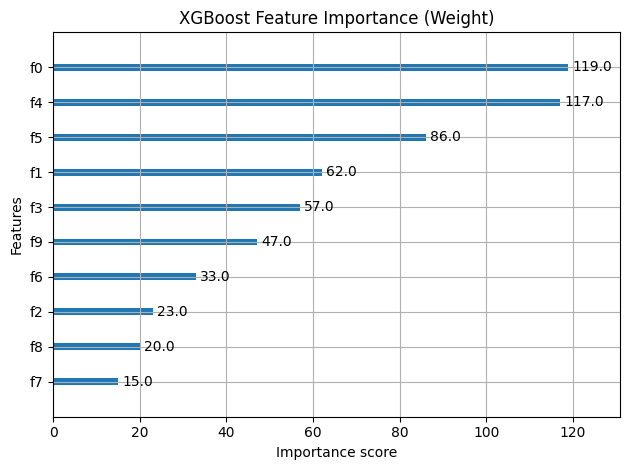

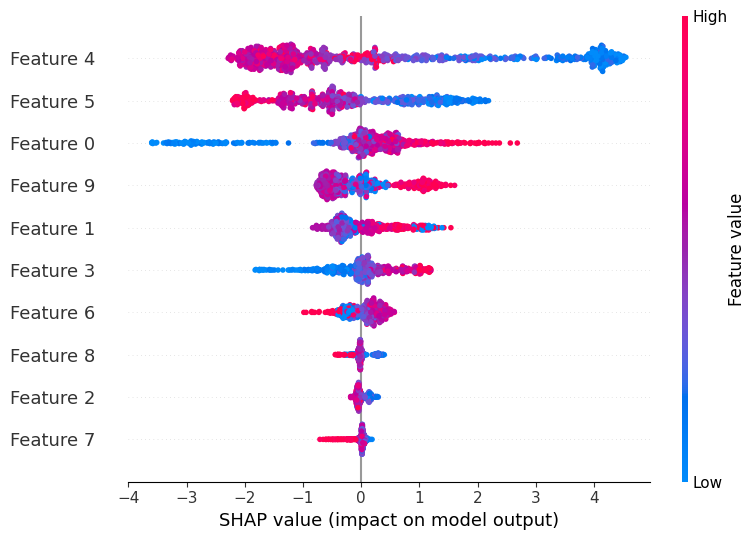

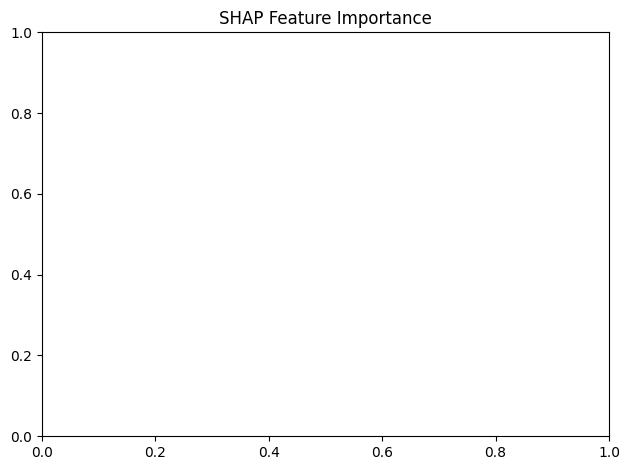

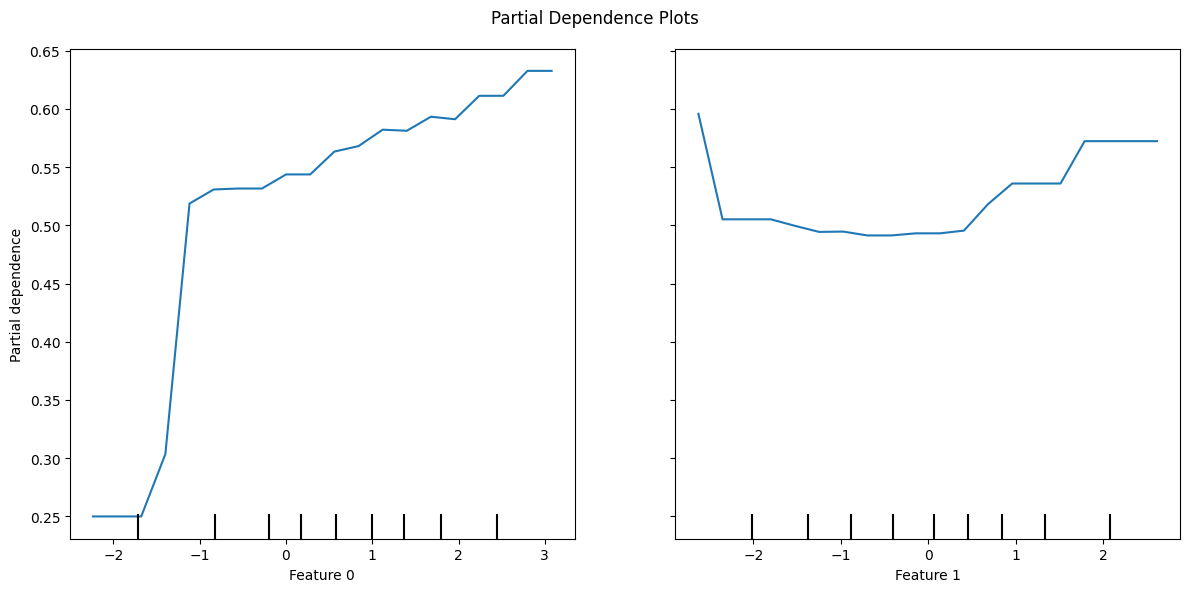

<Figure size 600x600 with 0 Axes>

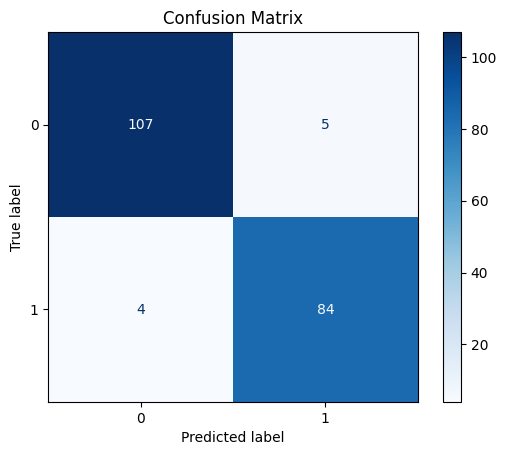

In [43]:
# Import all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import ConfusionMatrixDisplay
from xgboost import XGBClassifier, plot_importance

# 1. Create synthetic dataset (replace with your actual data)
X, y = make_classification(
    n_samples=1000,
    n_features=10,
    n_informative=5,
    n_redundant=2,
    random_state=42
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Train XGBoost model
model = XGBClassifier(
    objective='binary:logistic',
    max_depth=3,
    learning_rate=0.1,
    n_estimators=100,
    eval_metric='logloss',
    random_state=42,
    use_label_encoder=False
)
model.fit(X_train, y_train)

# 3. Feature Importance Plot
plt.figure(figsize=(10, 6))
plot_importance(model, importance_type='weight')
plt.title('XGBoost Feature Importance (Weight)')
plt.tight_layout()
plt.show()

# 4. SHAP Values Analysis
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_train, feature_names=[f'Feature {i}' for i in range(X.shape[1])])
plt.title('SHAP Feature Importance')
plt.tight_layout()
plt.show()

# 5. Partial Dependence Plots
fig, ax = plt.subplots(figsize=(12, 6))
PartialDependenceDisplay.from_estimator(
    model,
    X_train,
    features=[0, 1],  # Plot first two features
    feature_names=[f'Feature {i}' for i in range(X.shape[1])],
    ax=ax,
    grid_resolution=20
)
plt.suptitle('Partial Dependence Plots')
plt.tight_layout()
plt.show()

# 6. Confusion Matrix
plt.figure(figsize=(6, 6))
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

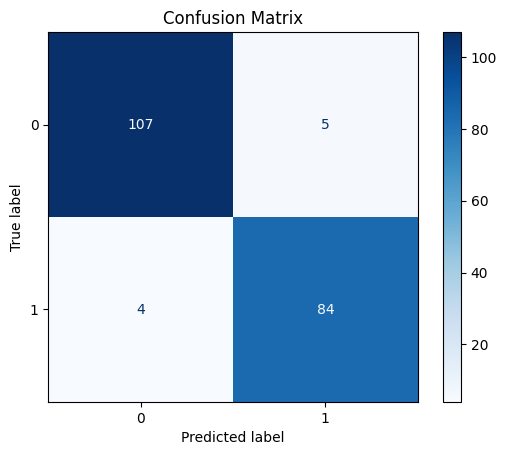

Accuracy: 0.9550
Precision: 0.9438
Recall: 0.9545

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       112
           1       0.94      0.95      0.95        88

    accuracy                           0.95       200
   macro avg       0.95      0.95      0.95       200
weighted avg       0.96      0.95      0.96       200



In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score

# Generate predictions
y_pred = model.predict(X_test)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)  # For binary classification
recall = recall_score(y_test, y_pred)       # For binary classification

# For multi-class classification, use these instead:
# precision = precision_score(y_test, y_pred, average='weighted')
# recall = recall_score(y_test, y_pred, average='weighted')

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Additional detailed report
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime


# Extract time features
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.day
df['month'] = df['timestamp'].dt.month
df['day_name'] = df['timestamp'].dt.day_name()

C:\Users\oba phillip\AppData\Local\Temp\ipykernel_8660\1728586682.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x='hour', y='target_congestion_level', ci=None)


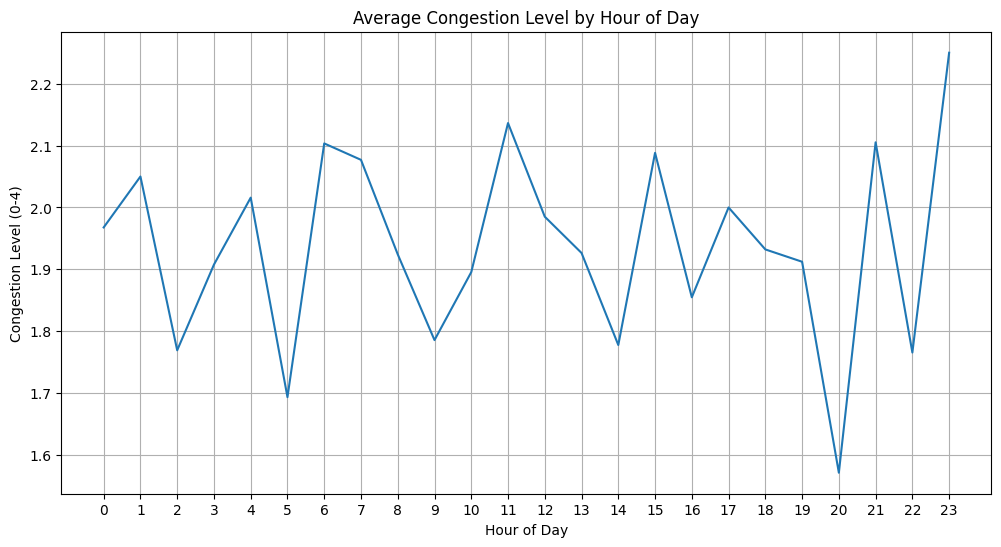

In [46]:
# 1. Traffic Congestion by Time of Day
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='hour', y='target_congestion_level', ci=None)
plt.title('Average Congestion Level by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Congestion Level (0-4)')
plt.xticks(range(24))
plt.grid()
plt.show()

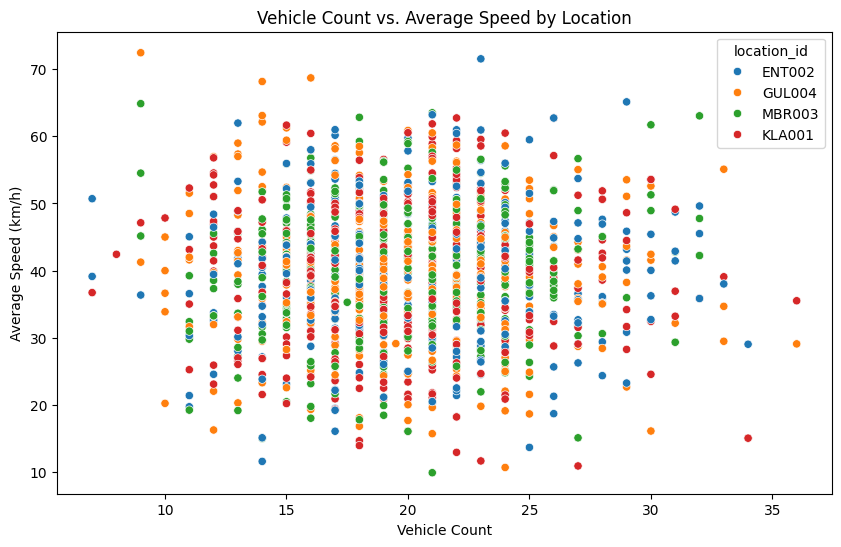

In [47]:
# 2. Vehicle Count vs. Average Speed by Location
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='vehicle_count', y='avg_speed', hue='location_id')
plt.title('Vehicle Count vs. Average Speed by Location')
plt.xlabel('Vehicle Count')
plt.ylabel('Average Speed (km/h)')
plt.show()

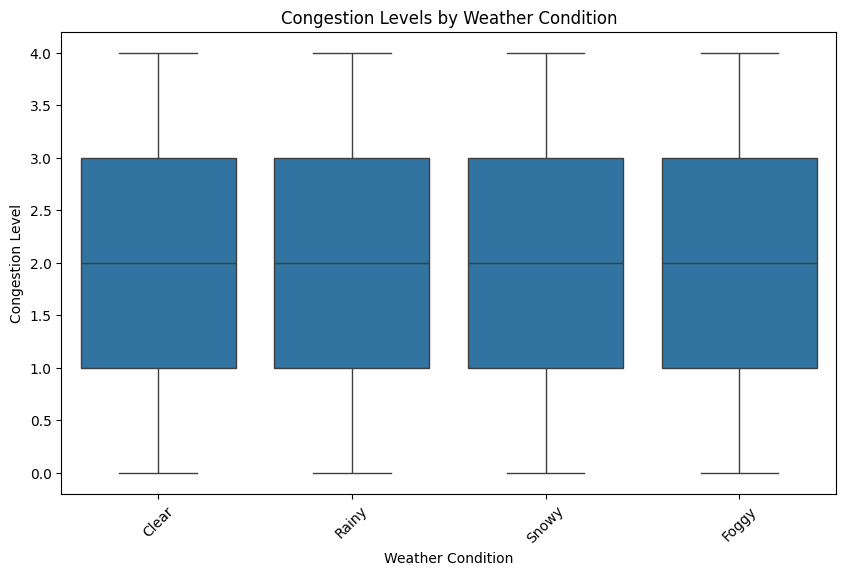

In [48]:
 # 3. Congestion Level by Weather Condition
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='weather', y='target_congestion_level')
plt.title('Congestion Levels by Weather Condition')
plt.xlabel('Weather Condition')
plt.ylabel('Congestion Level')
plt.xticks(rotation=45)
plt.show()

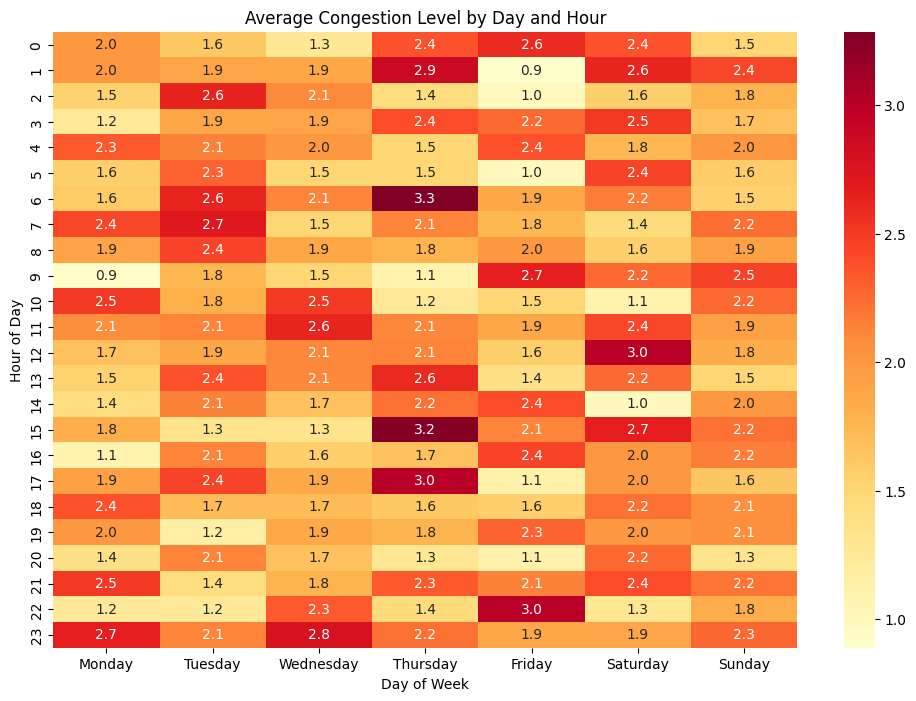

In [49]:
# 4. Heatmap of Congestion by Day and Hour
# Create pivot table for heatmap
heatmap_data = df.pivot_table(index='hour', columns='day_name', 
                             values='target_congestion_level', aggfunc='mean')

# Reorder columns by day of week
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data[days]

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='YlOrRd', annot=True, fmt='.1f')
plt.title('Average Congestion Level by Day and Hour')
plt.xlabel('Day of Week')
plt.ylabel('Hour of Day')
plt.show()

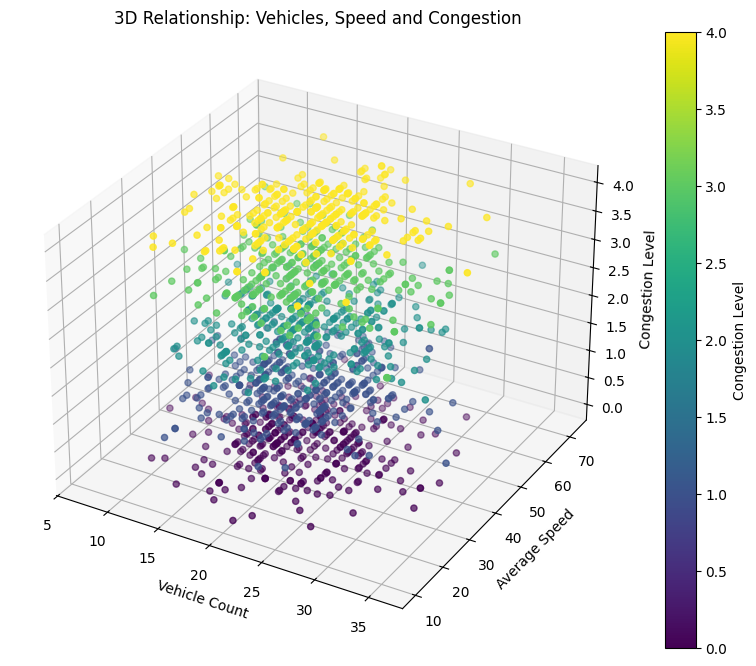

In [50]:
from mpl_toolkits.mplot3d import Axes3D
# 5. 3D Plot of Vehicle Count, Speed and Congestion
# Prepare data
plot_df = df.dropna(subset=['vehicle_count', 'avg_speed', 'target_congestion_level'])

# Create figure
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(plot_df['vehicle_count'], 
                    plot_df['avg_speed'], 
                    plot_df['target_congestion_level'],
                    c=plot_df['target_congestion_level'],
                    cmap='viridis')

# Labels
ax.set_xlabel('Vehicle Count')
ax.set_ylabel('Average Speed')
ax.set_zlabel('Congestion Level')
plt.title('3D Relationship: Vehicles, Speed and Congestion')
plt.colorbar(scatter, label='Congestion Level')
plt.show()

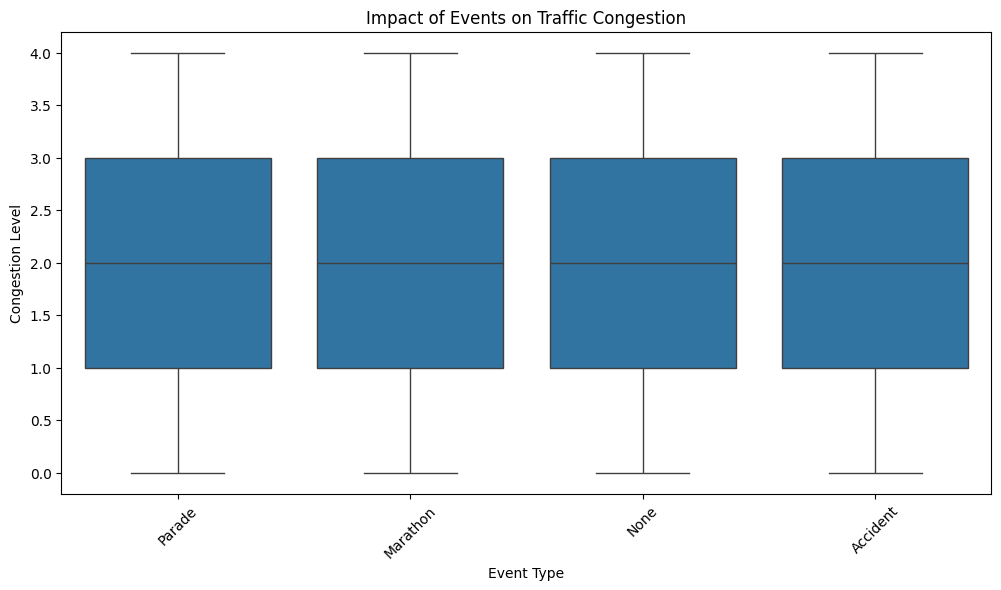

In [51]:
# 6. Impact of Events on Congestion
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='event', y='target_congestion_level')
plt.title('Impact of Events on Traffic Congestion')
plt.xlabel('Event Type')
plt.ylabel('Congestion Level')
plt.xticks(rotation=45)
plt.show()

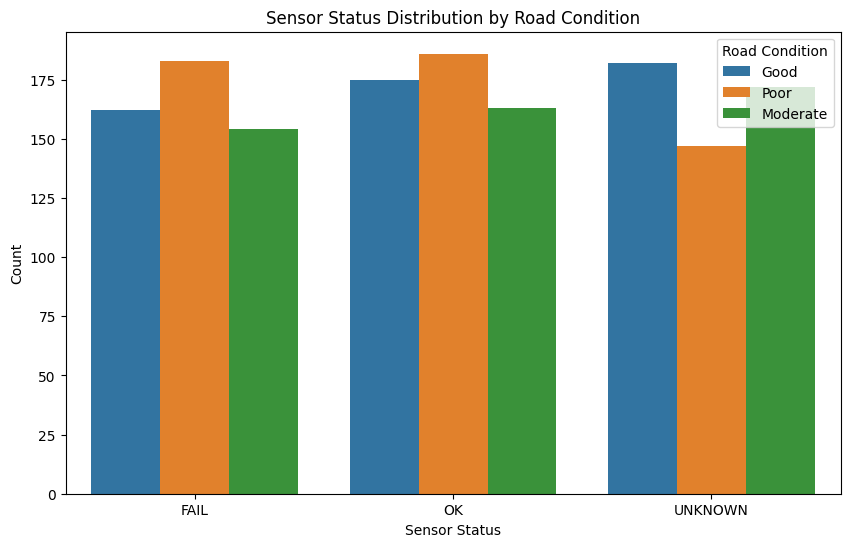

In [52]:
# 7. Sensor Status Impact on Data Quality
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='sensor_status', hue='road_condition')
plt.title('Sensor Status Distribution by Road Condition')
plt.xlabel('Sensor Status')
plt.ylabel('Count')
plt.legend(title='Road Condition')
plt.show()

C:\Users\oba phillip\AppData\Local\Temp\ipykernel_8660\253249314.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts_data = df.set_index('timestamp').resample('H')['target_congestion_level'].mean()


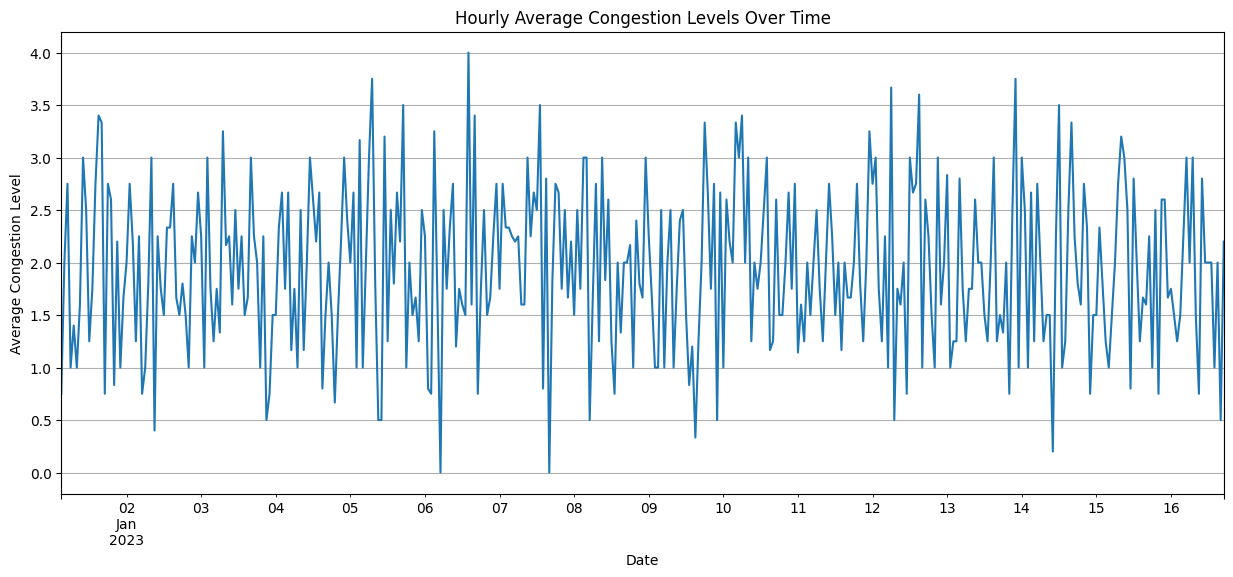

In [53]:
# 8. Time Series of Congestion Levels
# Resample to hourly averages
ts_data = df.set_index('timestamp').resample('H')['target_congestion_level'].mean()

plt.figure(figsize=(15, 6))
ts_data.plot()
plt.title('Hourly Average Congestion Levels Over Time')
plt.xlabel('Date')
plt.ylabel('Average Congestion Level')
plt.grid()
plt.show()

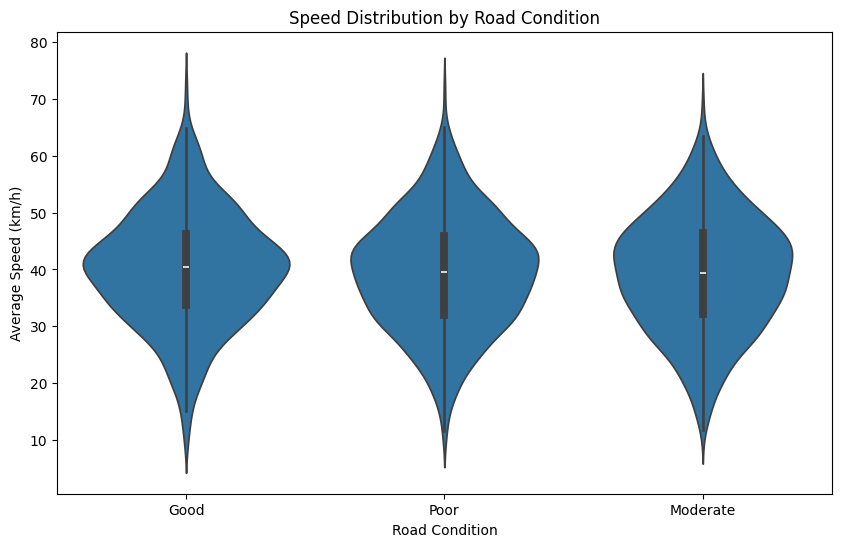

In [54]:
# 9. Road Condition Impact on Speed
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='road_condition', y='avg_speed')
plt.title('Speed Distribution by Road Condition')
plt.xlabel('Road Condition')
plt.ylabel('Average Speed (km/h)')
plt.show()

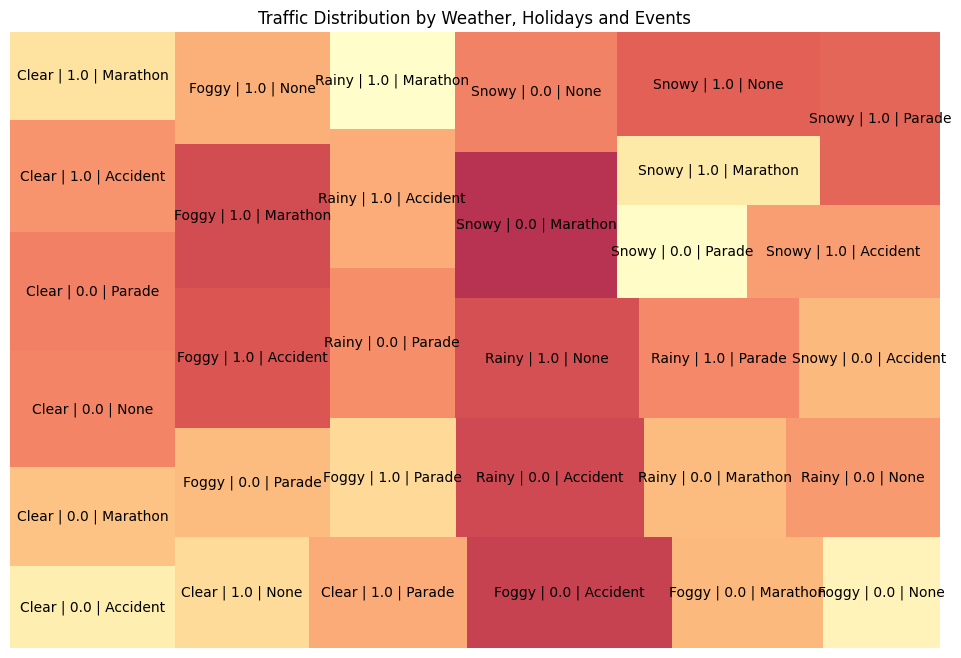

In [55]:
import squarify

#10. Interactive Sunburst Chart of traffic distribution
# Prepare data
tree_data = df.groupby(['weather', 'is_holiday', 'event'])['vehicle_count'].sum().reset_index()
tree_data['label'] = tree_data['weather'] + ' | ' + tree_data['is_holiday'].astype(str) + ' | ' + tree_data['event']

# Create treemap
plt.figure(figsize=(12, 8))
squarify.plot(sizes=tree_data['vehicle_count'], 
              label=tree_data['label'],
              alpha=0.8,
              color=plt.cm.RdYlGn_r(tree_data['vehicle_count']/tree_data['vehicle_count'].max()))
plt.title('Traffic Distribution by Weather, Holidays and Events')
plt.axis('off')
plt.show()

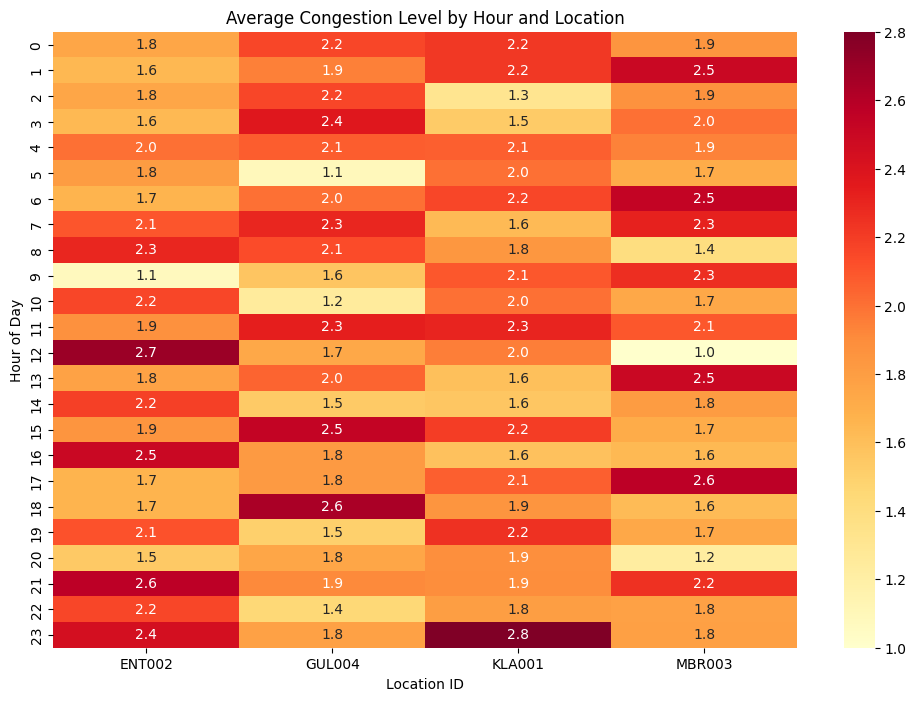

In [56]:
# 3. Heatmap of Average Congestion by Hour and Location
# Create pivot table
heatmap_data = df.pivot_table(index='hour', 
                             columns='location_id', 
                             values='target_congestion_level', 
                             aggfunc='mean')

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='YlOrRd', annot=True, fmt='.1f')
plt.title('Average Congestion Level by Hour and Location')
plt.xlabel('Location ID')
plt.ylabel('Hour of Day')
plt.show()

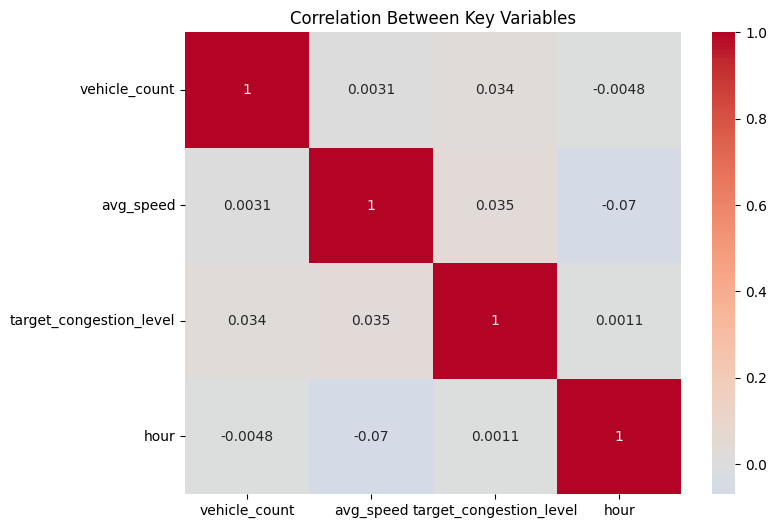

In [57]:
# Calculate correlations
corr = df[['vehicle_count', 'avg_speed', 'target_congestion_level', 'hour']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Between Key Variables')
plt.show()

In [58]:
import altair as alt
import pandas as pd

# Sample: replace with your actual DataFrame
# df = pd.read_csv("your_data.csv")

# Select variables of interest
cols = ['vehicle_count', 'avg_speed', 'target_congestion_level', 'location_id']

# Melt the DataFrame for pairwise plotting
scatter = alt.Chart(df).mark_circle(size=60).encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
    color='location_id:N',
    tooltip=cols
).properties(
    width=150,
    height=150
).repeat(
    row=['vehicle_count', 'avg_speed', 'target_congestion_level'],
    column=['vehicle_count', 'avg_speed', 'target_congestion_level']
).interactive()

scatter.show()


alt.RepeatChart(...)

In [64]:
import joblib
import json
import pandas as pd

# 1. Get column names BEFORE converting to NumPy array
# (Do this right after your initial DataFrame creation)
feature_columns = list(df.drop(columns=['target_congestion_level']).columns)

# 2. Save these names immediately
with open('xgboost_feature_columns.json', 'w') as f:
    json.dump(feature_columns, f)

# 3. Proceed with your model training
# ... (your existing code that creates X as NumPy array)

# 4. Save model
joblib.dump(model, 'xgboost_traffic_congestion_model.pkl')

['xgboost_traffic_congestion_model.pkl']